# Dataset preperation

# Enabling GPU

In [1]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name NVIDIA GeForce RTX 2070


# DataLoader


In [2]:
import glob
import numpy as np
import torchvision.transforms as T

from torchvision.transforms.functional import adjust_gamma
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from preprocessing import *
from helper import *
from PIL import Image


class SimDataset(Dataset):
    def __init__(self, image_path, mask_path):
        # TODO
        # 1. Initialize file paths or a list of file names. 
        self.input_images = glob.glob(str(image_path) + str("/*"))
        self.target_masks = glob.glob(str(mask_path) + str("/*"))
        
    def __len__(self):
        return len(self.target_masks)
        
    def __getitem__(self, idx):
                
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        image = self.input_images[idx]
        img_as_img = Image.open(image)
        img_as_np = np.asarray(img_as_img)

        # Normalize the image
        img_as_np = clahe_equalized (img_as_np)
        img_as_np = adjust_gamma(img_as_np, 1.2)
        img_as_np = normalization(img_as_np, max=1, min=0)
        img_as_np = np.expand_dims(img_as_np, axis=0)  # add additional dimension
        img_as_tensor = torch.from_numpy(img_as_np).float()  # Convert numpy array to tensor
       
        """
        # GET MASK
        """        
        mask = self.target_masks[idx]
        mask_as_mask = Image.open(mask)

        msk_as_np = np.asarray(mask_as_mask)
        msk_as_np = msk_as_np/255
        msk_as_np = np.expand_dims(msk_as_np, axis=0)
        msk_as_tensor = torch.from_numpy(msk_as_np).float()  # Convert numpy array to tensor

        return (img_as_tensor, msk_as_tensor)

train_set = SimDataset('final-dataset/train/images', 'final-dataset/train/masking')
val_set = SimDataset('final-dataset/val/images', 'final-dataset/val/masking')
test_set = SimDataset('final-dataset/test/images', 'final-dataset/test/masking')

n_train = len(train_set)
print("n_train=",n_train)

valid_size = 0.1

indices = list(range(n_train))
split = int(np.floor(valid_size * n_train))
np.random.shuffle(indices)
from torch.utils.data.sampler import SubsetRandomSampler
train_idx, val_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

trainloaders = torch.utils.data.DataLoader(train_set, sampler=train_sampler, batch_size=20)
valloaders = torch.utils.data.DataLoader(train_set, sampler=val_sampler, batch_size=10)

print("num_train = ", len(train_sampler))
print("num_val = ", len(val_sampler))

n_train= 2552
num_train =  2297
num_val =  255


# Create U-NET Model Function

In [3]:
import torch
import torch.nn as nn
from torchsummary import summary

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

# Train U-NET

cuda:0


c:\Users\USER\anaconda3\envs\unet\Lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


saving best model =  0.25521325568358105
Epoch 1/100, Training Loss: 0.313, Val Loss: 0.255, Time: 648.0281484127045s
saving best model =  0.23681176293130016
Epoch 2/100, Training Loss: 0.230, Val Loss: 0.238, Time: 355.2426462173462s
saving best model =  0.22391613587444903
Epoch 3/100, Training Loss: 0.220, Val Loss: 0.224, Time: 349.5505497455597s
saving best model =  0.20775389145402348
Epoch 4/100, Training Loss: 0.208, Val Loss: 0.209, Time: 348.6705176830292s
saving best model =  0.1941001418174482
Epoch 5/100, Training Loss: 0.199, Val Loss: 0.194, Time: 348.7334098815918s
saving best model =  0.1879518081744512
Epoch 6/100, Training Loss: 0.184, Val Loss: 0.187, Time: 347.2073438167572s
saving best model =  0.16863193202252483
Epoch 7/100, Training Loss: 0.177, Val Loss: 0.168, Time: 346.2455241680145s
Epoch 8/100, Training Loss: 0.166, Val Loss: 0.183, Time: 345.8649446964264s
saving best model =  0.15336456164425494
Epoch 9/100, Training Loss: 0.157, Val Loss: 0.153, Time: 

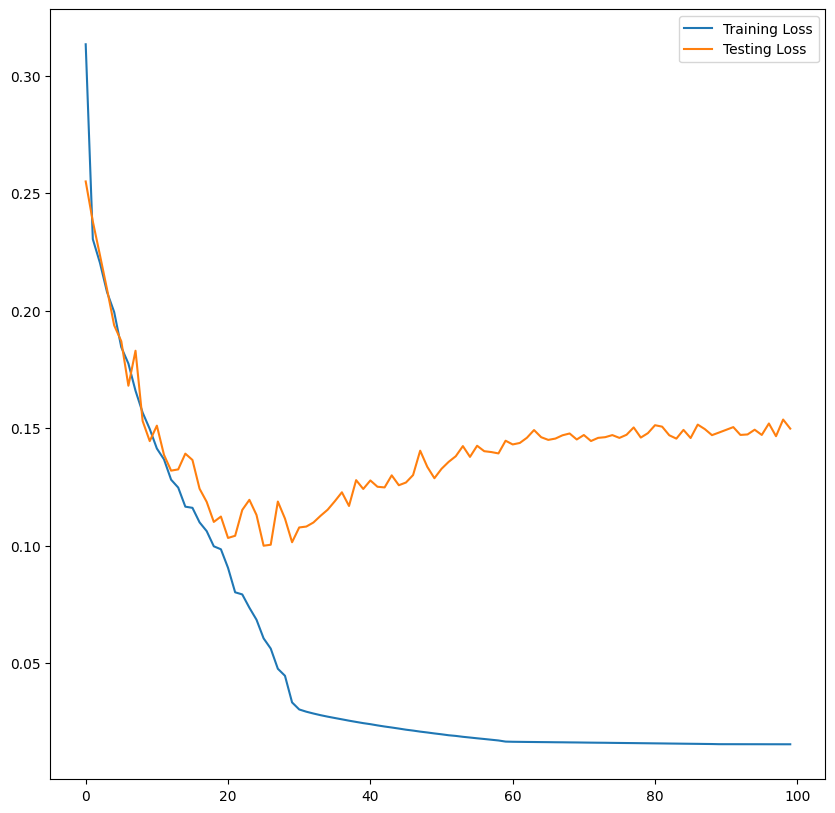

In [4]:
import torch.nn.functional as F
import torch.optim as optim
import time
import copy
from collections import defaultdict
from torch.optim import lr_scheduler
from tqdm.notebook import trange, tqdm
# from sklearn.metrics import accuracy_score, precision_score, f1_score
import gc


#def calc_loss(pred, target, metrics, bce_weight=1.0):
#    bce = F.binary_cross_entropy_with_logits(pred, target)
##    bce = F.binary_cross_entropy(pred, target)
#
##    pred = F.sigmoid(pred)
#    dice = dice_loss(pred, target)
#
#    loss = bce * bce_weight + dice * (1 - bce_weight)
#
#    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
#
#    return loss
#
#def print_metrics(metrics, epoch_samples, phase):
#    outputs = []
#    for k in metrics.keys():
#        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
#
#    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, loss_fn, num_epochs=100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        since = time.time()

        # Each epoch has a training and validation phase
        scheduler.step()
        model.train()
#        metrics = defaultdict(float)
        met_train = 0.0
        epoch_samples = 0
        iter_loss = 0.0
        iterations = 0
        
        for inputs, labels in trainloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
#            print("min max input = ", inputs.min(), inputs.max())
#            print("min max label = ", labels.min(), labels.max())
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
#                print("min max outputs = ", outputs.min(), outputs.max())
#                loss = calc_loss(outputs, labels, metrics)
#                loss = F.binary_cross_entropy(outputs, labels)
                loss = loss_fn(outputs, labels)

                # backward + optimize only if in training phase
                iter_loss += loss.item()
                loss.backward()
                optimizer.step()
                
            met_train += loss.data.cpu().numpy() * labels.size(0)
            # statistics
            epoch_samples += inputs.size(0)
            iterations += 1
            
#        print_metrics(metrics, epoch_samples, "train")
#        epoch_loss = metrics['loss'] / epoch_samples
        epoch_loss = met_train / epoch_samples
        train_loss.append(iter_loss/iterations)
        
        # deep copy the model
        model.eval()
#        metrics = defaultdict(float)
        epoch_samples = 0
        iter_val_loss = 0.0
        iterations = 0
        met_val = 0.0
            
        for inputs, labels in valloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
           
            # zero the parameter gradients
#            optimizer.zero_grad()
            with torch.no_grad():
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
#                print("loss=",loss)
                iter_val_loss += loss.item()
            
            # statistics
            met_val += loss.data.cpu().numpy() * labels.size(0)
            epoch_samples += inputs.size(0)
            iterations += 1
        
#        print_metrics(metrics, epoch_samples, "val")
#        epoch_loss = metrics['loss'] / epoch_samples
        epoch_loss = met_val / epoch_samples   
            
        val_loss.append(iter_val_loss/iterations)
                     
        if epoch_loss < best_loss:
            print("saving best model = ", epoch_loss)
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(),'Unet_Model.pth')
            
#        time_elapsed = time.time() - since
#        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        stop = time.time()
    
        print ('Epoch {}/{}, Training Loss: {:.3f}, Val Loss: {:.3f}, Time: {}s'
               .format(epoch+1, num_epochs, train_loss[-1], val_loss[-1], stop-since))
        # load best model weights
    print('Best val loss: {:4f}'.format(best_loss))
    model.load_state_dict(best_model_wts)
    
    return model, train_loss, val_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1
model = UNet(num_class).to(device)
loss_fn = nn.BCEWithLogitsLoss()

# freeze backbone layers
#for l in model.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model, train_loss, val_loss = train_model(model, optimizer_ft, exp_lr_scheduler, loss_fn, num_epochs=100)

# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss')
plt.legend()
plt.show()

# Predict U-NET

cuda:0


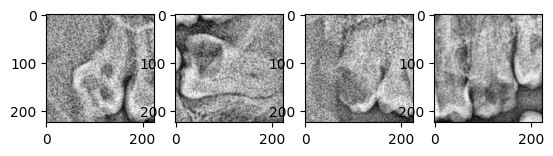

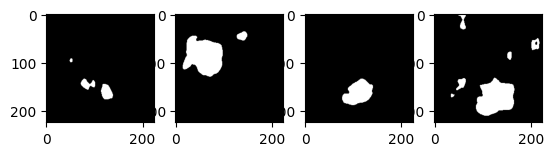

(224, 224, 1)
None


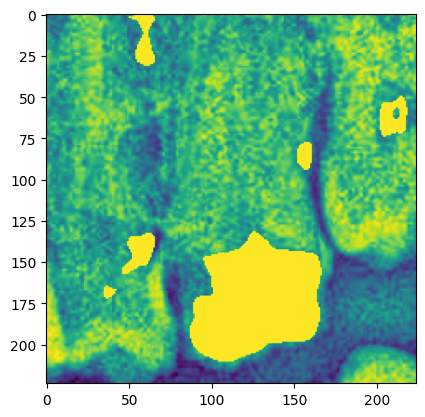

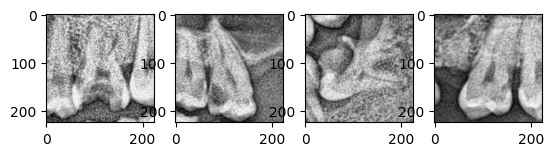

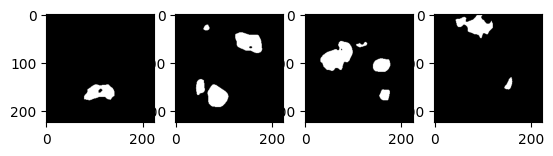

(224, 224, 1)
None


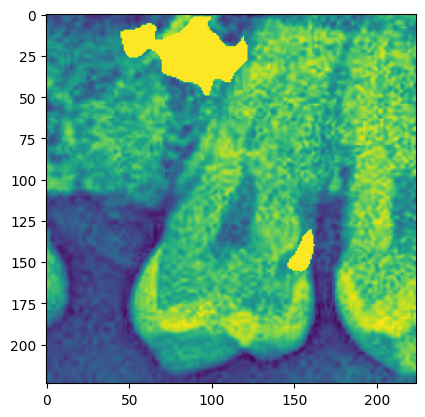

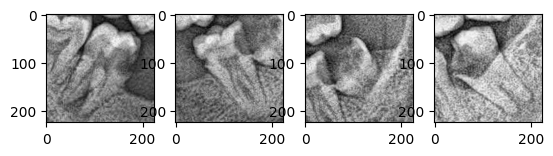

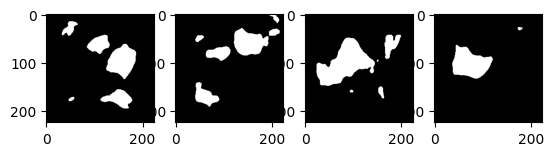

(224, 224, 1)
None


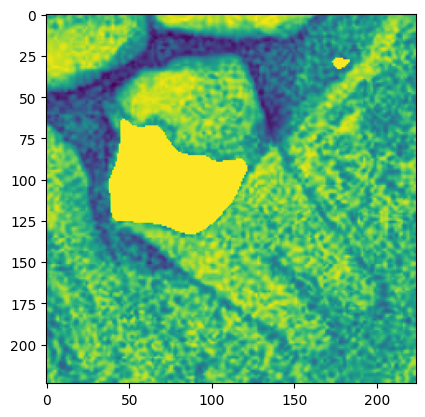

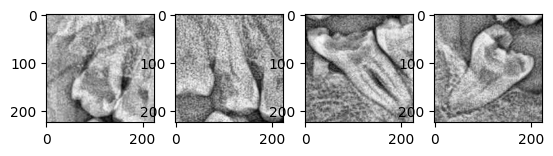

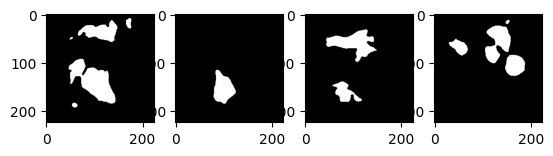

(224, 224, 1)
None


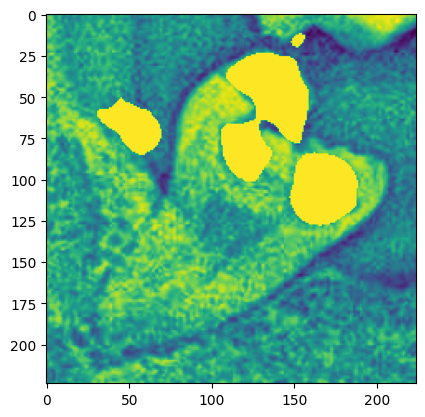

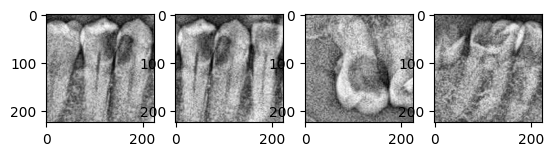

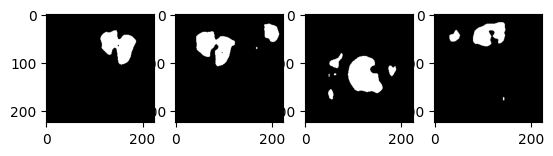

(224, 224, 1)
None


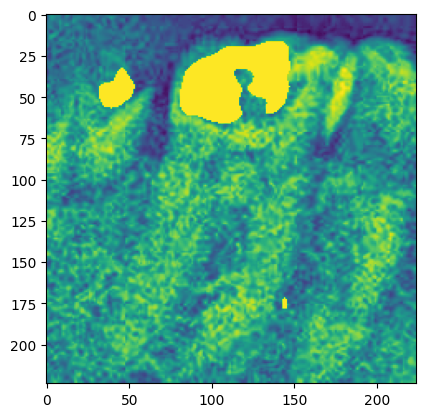

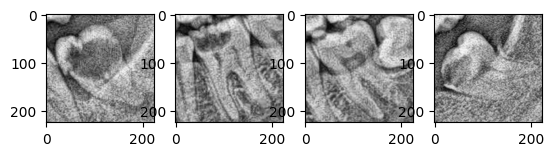

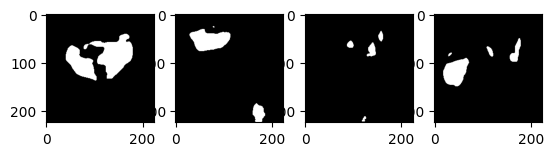

(224, 224, 1)
None


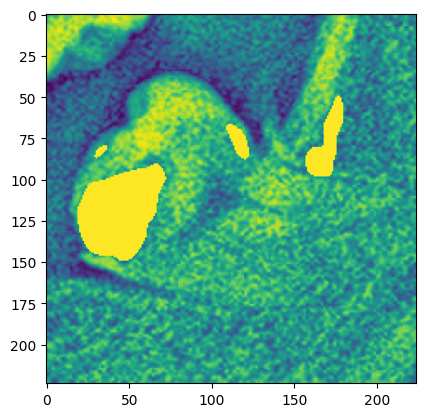

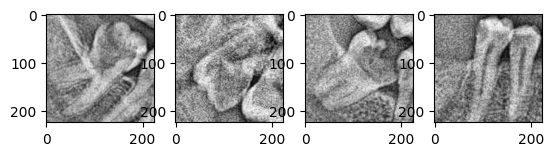

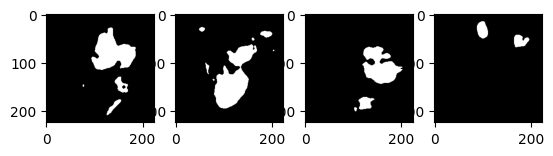

(224, 224, 1)
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\unet\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_9232\3757366884.py", line 109, in <module>
    print(combine_image(inputs_cpu[i], pred[i]))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_9232\3757366884.py", line -1, in combine_image
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\unet\Lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\unet\Lib\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_t

: 

In [68]:
import math
import torch
# from dataset_v2 import *
# from Unet import *
import numpy as np
import matplotlib.pyplot as plt
import cv2

#def imshow(img):
##    img = img / 2 + 0.5     # unnormalize
#    npimg = img.numpy()
##    plt.figure(figsize=(10,10))
##    plt.axis('off')
#    plt.imshow(np.transpose(npimg, (1, 2, 0)))
##    plt.pause(0.001)

test_set = SimDataset('final-dataset/test/images', 'final-dataset/test/masking')
testloaders = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1
model = UNet(num_class).to(device)

model.load_state_dict(torch.load('Unet_Model.pth'))

model.eval()   # Set model to the evaluation mode

def reverse_transform(inp):
    inp = inp.transpose((1, 2, 0))
    new_inp = np.zeros((inp.shape[0],inp.shape[1],3))
    for ch in range(new_inp.shape[2]):
        for i in range(new_inp.shape[0]):
            for j in range(new_inp.shape[1]):
                if inp[i,j]>0.0:
                    new_inp[i,j,ch]=1.0
                else:
                    new_inp[i,j,ch]=0.0
#    for ch in range(new_inp.shape[2]):
#        for i in range(new_inp.shape[0]):
#            for j in range(new_inp.shape[1]):
#                if new_inp[i,j,ch]>0.5:
#                    new_inp[i,j,ch]=1.0
#                else:
#                    new_inp[i,j,ch]=0.0
#    mean = 0.42600167
#    std = 0.20886457
#    new_inp = std * new_inp + mean
#    new_inp = np.clip(inp, 0, 1)
    new_inp = (new_inp * 255).astype(np.uint8)
#    print(new_inp.shape, new_inp.min(), new_inp.max())
#    print("new_inp=", new_inp)

    return new_inp

def reverse_transform_input(inp):
    inp = inp.transpose((1, 2, 0))
    new_inp = np.zeros((inp.shape[0],inp.shape[1],3))
    for ch in range(new_inp.shape[2]):
        for i in range(new_inp.shape[0]):
            for j in range(new_inp.shape[1]):
                new_inp[i,j,ch]=inp[i,j]
    new_inp = (new_inp * 255).astype(np.uint8)
#    print(new_inp.shape, new_inp.min(), new_inp.max())
#    print("new_inp=", new_inp)

    return new_inp

def combine_image(input, pred):
    input = input.transpose((1, 2, 0))
    pred = pred.transpose((1, 2, 0))
    print(pred.shape)
    for ch in range(pred.shape[2]):
        for i in range(pred.shape[0]):
            for j in range(pred.shape[1]):
                if pred[i,j]>0.0 and ch==0:
                    input[i,j,0]=1
    
    plt.imshow(input)

for inputs, labels in testloaders:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Predict
    pred = model(inputs)
    # print(pred.shape)
    # print(pred.min(), pred.max())
    # The loss functions include the sigmoid function.
#    pred = F.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    inputs_cpu = inputs.data.cpu().numpy()
#    print(pred.shape, pred.min(), pred.max())
#    print(pred.shape)

    #plt.imshow(reverse_transform(pred[0]))
    plt.figure()
    for i in range(pred.shape[0]):
        plt.subplot(1, pred.shape[0],i+1)
        plt.imshow(reverse_transform_input(inputs_cpu[i]))
    #    plt.imshow(reverse_transform(pred[i]))
    plt.show()
    plt.figure()
    for i in range(pred.shape[0]):
        plt.subplot(1, pred.shape[0],i+1)
        plt.imshow(reverse_transform(pred[i]))
    plt.show()

    print(combine_image(inputs_cpu[i], pred[i]))

#f = open("test_y", "w")
#with torch.no_grad():
#    for i, (images, labels) in enumerate(test_loader, 0):
#        outputs = model(images)
#        _, predicted = torch.max(outputs.data, 1)
#        sample_fname, _ = test_loader.dataset.samples[i]
#        f.write("{}, {}\n".format(sample_fname, predicted.item()))
#f.close()

#imshow(torchvision.utils.make_grid(inputs))


## Change channel-order and make 3 channels for matplot
#input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]
#
## Map each channel (i.e. class) to each color
#target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
#pred_rgb = [helper.masks_to_colorimg(x) for x in pred]
#
#helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])